# NA 565 Example Session 1 - Linear Quadratic Control

In the example session, we will implement the Linear Quadratic Regulator (LQR). 

We will discuss:

1. The implementation using linear algebra technique, 

2. The implementation using Quadratic Programming (CVX), 

3. The influence of preview horizon for LQR, 

4. The controllability, if time permitted. 


# Linear Quadratic Regulator (LQR)

We consider a discrete-time dynamical system, with state $x_k \in \mathbb{R}^n$, and control input $u_k \in \mathbb{R}^{m}$:

$x_{k+1} = A_k x_k + B_k u_k$. 

We assume the system starts from initial condition $x_0 = x_{init}$, and our goal is to regularize state to $x = 0$. 

Then we can define the $N$-step LQR, with the weighting matrix $L$ for terminal states, $Q$ and $R$ for intermediate states and control:

$
\begin{equation}
    \begin{aligned}
    \min_{x_k,  u_k} & \  \frac{1}{2} x_N^TL x_N + \sum_{k=0}^{N-1}  \frac{1}{2}x_k^TQ x_k +  \frac{1}{2}u_k^TR u_k \\ 
    \text{s.t. } \quad & x_{k+1} = A_k x_{k} + B_k u_k, \\
                       & x_0 =  x_{init}, \\ 
                       & x_N =  x_{des}, \\
                       & k = 0, \dots, N-1.
    \end{aligned}
\end{equation}
$



# Closed-form solution of LQR via KKT condition

## KKT condition for standard QP
For QP in the form, with $P > 0$:

$$
\begin{equation}
    \begin{aligned}
    \min_{s}  \quad &\frac{1}{2}s^{T}Ps + q^{T}s \\ 
    \text{s.t. } \quad & Cs= d,
    \end{aligned}
\end{equation}
$$

we can obtain the closed form solution via KKT condition:

$$
\begin{aligned}
\mathcal{L}(s, u, \lambda) &= \frac{1}{2}s^{T}Ps + q^{T}s + \lambda^{T}(Cs + d),  \\
\nabla_x \mathcal{L}(s, u, \lambda) &= Ps + q + C^{T}\lambda = 0, \\
\nabla_\lambda \mathcal{L}(s, u, \lambda) &= Cx - d = 0, 
\end{aligned}
$$

which is:

$$
\begin{bmatrix} P & C^{T} \\
                C & 0                
\end{bmatrix}

\begin{bmatrix} s \\
                \lambda                
\end{bmatrix}
=
\begin{bmatrix} -q \\
                d                
\end{bmatrix}
$$

## Convert the LQR to standar QP
$$
\begin{gathered}
{P}=\left[\begin{array}{ccc|ccc}
Q_0 & \cdots & 0 & 0 & \cdots & 0 \\
\vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
0 & \cdots & P & 0 & \cdots & 0 \\
\hline 0 & \cdots & 0 & R_0 & \cdots & 0 \\
\vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
0 & \cdots & 0 & 0 & \cdots & R_{N-1}
\end{array}\right], \quad {q}=0 \\
{C}=\left[\begin{array}{cccccc|cccc}
A_0 & -I & 0 & \cdots & 0 & 0 & B_0 & 0 & \cdots & 0 \\
0 & A_1 & -I & \cdots & 0 & 0 & 0 & B_1 & \cdots & 0 \\
\vdots & \vdots & \vdots & & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & A_{N-1} & -I & 0 & 0 & \cdots & B_{N-1} \\
\hline I & 0 & 0 & \cdots & 0 & 0 & 0 & 0 & \cdots & 0 \\
0 & 0 & 0 & \cdots & 0 & I & 0 & 0 & \cdots & 0
\end{array}\right], \quad {d}=\left[\begin{array}{c}
0 \\
0 \\
\vdots \\
0 \\
\hline x^{\text {init }} \\
x^{\text {des }}
\end{array}\right]
\end{gathered}
$$

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

from plot_utils import *

## CVX Tutorial

Install CVX: https://www.cvxpy.org/install/

A basic QP example: https://www.cvxpy.org/examples/basic/quadratic_program.html

In [2]:
# Import packages.
import cvxpy as cp
import numpy as np

# Generate a random non-trivial quadratic program.
m = 15
n = 10
p = 5
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

# Define and solve the CVXPY problem.
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),
                 [G @ x <= h,
                  A @ x == b])
prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution corresponding to the inequality constraints is")
print(prob.constraints[0].dual_value)


The optimal value is 86.89141585569907
A solution x is
[-1.68244521  0.29769913 -2.38772183 -2.79986015  1.18270433 -0.20911897
 -4.50993526  3.76683701 -0.45770675 -3.78589638]
A dual solution corresponding to the inequality constraints is
[ 0.          0.          0.          0.          0.         10.45538054
  0.          0.          0.         39.67365045  0.          0.
  0.         20.79927156  6.54115873]


## A simple linear system simulator

In [3]:
def sim_LinSys(x0, Ad, Bd, controller, N_sim, preview):

    dim_state = Ad.shape[0]
    dim_ctrl  = Bd.shape[1]

    x_log = np.zeros((N_sim + 1, dim_state))
    u_log = np.zeros((N_sim, dim_ctrl ))

    x_log[0, :] = np.squeeze(x0)

    for k in range(N_sim):

        output = controller(x_log[k, :], Ad, Bd, preview, dim_state, dim_ctrl)
        u_act = output[0]

        u_act = np.reshape(u_act, [dim_ctrl, 1])
        xkp1 = Ad @ np.reshape(x_log[k, :], [dim_state, 1])  + Bd @ u_act

        x_log[k + 1, :] = np.squeeze(xkp1)
        u_log[k, :]     = np.squeeze(u_act)
    
    return x_log, u_log

def void_controller(x0, Ad, Bd, preview, dim_state, dim_ctrl):
    return [np.zeros(dim_ctrl)]

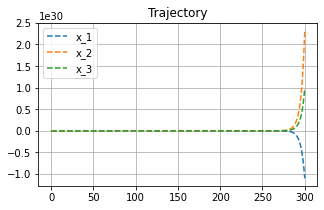

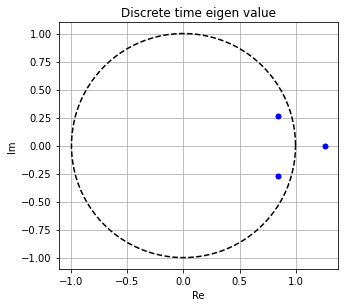

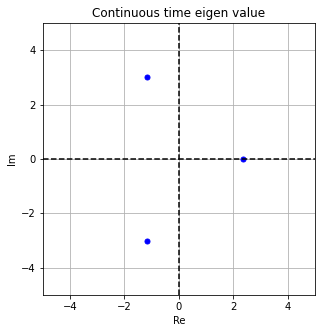

In [4]:
## Now we generate an linear system and discretize it
dt = 0.1
Bc = np.array([[0, 0], 
               [1, 0],
               [0, 1]])

Ac = np.array([[0, 1, -5],
               [-5, 0, 0],
               [0, 1, 0]]) ## Unstable case. About the eigen values, 
               

## I am using the infinite series ...
Ad = np.eye(3) + Ac * dt + Ac @ Ac * dt**2 / 2
Bd = Bc * dt # + Ac @ Bc * dt**2 / 2

x0 = np.random.randn(3, 1)

N_sim = 300
preview = 2

x_log, u_log = sim_LinSys(x0, Ad, Bd, void_controller, N_sim, preview)

plt.figure(figsize=(5, 3))

plt.plot(x_log[:, 0], '--', label = "x_1")
plt.plot(x_log[:, 1], '--', label = "x_2")
plt.plot(x_log[:, 2], '--', label = "x_3")

plt.title('Trajectory')
plt.legend()
plt.grid()
plt.show()


### Discrete time eigen values
ev, _= np.linalg.eig(Ad)

plt.figure(figsize=(5, 5))
plt.gca().set_aspect('equal')

for a in ev:
    plt.plot(a.real, a.imag, 'b.', markersize = 10)
plt.plot(np.cos(np.linspace(0, np.pi * 2, 100)), np.sin(np.linspace(0, np.pi * 2, 100)), "k--")

plt.title("Discrete time eigen value")
plt.xlabel("Re")
plt.ylabel("Im")

plt.grid()
plt.show()

### Continuous time eigen values
ev, _= np.linalg.eig(Ac)

plt.figure(figsize=(5, 5))
plt.gca().set_aspect('equal')

for a in ev:
    plt.plot(a.real, a.imag, 'b.', markersize = 10)



ah = 5.
plt.plot(np.linspace(-ah, ah, 100), np.linspace(-ah, ah, 100) * 0, "k--")
plt.plot(np.linspace(-ah, ah, 100) * 0, np.linspace(-ah, ah, 100), "k--")

plt.title("Continuous time eigen value")
plt.xlabel("Re")
plt.ylabel("Im")

plt.grid()
plt.xlim([-ah, ah])
plt.ylim([-ah, ah])
plt.show()

## Batch solution of LQR via KKT condition

### Remember the matrices
$$
\begin{gathered}
{P}=\left[\begin{array}{ccc|ccc}
Q_0 & \cdots & 0 & 0 & \cdots & 0 \\
\vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
0 & \cdots & P & 0 & \cdots & 0 \\
\hline 0 & \cdots & 0 & R_0 & \cdots & 0 \\
\vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
0 & \cdots & 0 & 0 & \cdots & R_{N-1}
\end{array}\right], \quad {q}=0 \\
{C}=\left[\begin{array}{cccccc|cccc}
A_0 & -I & 0 & \cdots & 0 & 0 & B_0 & 0 & \cdots & 0 \\
0 & A_1 & -I & \cdots & 0 & 0 & 0 & B_1 & \cdots & 0 \\
\vdots & \vdots & \vdots & & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & A_{N-1} & -I & 0 & 0 & \cdots & B_{N-1} \\
\hline I & 0 & 0 & \cdots & 0 & 0 & 0 & 0 & \cdots & 0 \\
0 & 0 & 0 & \cdots & 0 & I & 0 & 0 & \cdots & 0
\end{array}\right], \quad {d}=\left[\begin{array}{c}
0 \\
0 \\
\vdots \\
0 \\
\hline x^{\text {init }} \\
x^{\text {des }}
\end{array}\right]
\end{gathered}
$$

In [5]:
def LQR_linalg(x0, A, B, preview, dim_state, dim_ctrl):
    Q = np.eye(dim_state) * 1
    R = np.eye(dim_ctrl) * 20
    L = np.eye(dim_state) * 100

    n_u = dim_ctrl * preview
    n_x = dim_state * (preview + 1)

    n_var = n_u + n_x
    n_eq  = dim_state * (preview + 1) # dynamics

    # define the cost function

    C = np.zeros((n_eq, n_var))
    d = np.zeros((n_eq, 1))

    P = np.zeros((n_var, n_var))
    q = np.zeros((n_var, 1))
    for k in range(preview):
        P[k * dim_state:(k+1) * dim_state, k * dim_state:(k+1) * dim_state] = Q
        P[n_x + k * dim_ctrl:n_x + (k+1) * dim_ctrl, n_x + k * dim_ctrl:n_x + (k+1) * dim_ctrl] = R
    P[n_x - dim_state:n_x, n_x - dim_state:n_x] = L

    for k in range(preview):
        C[k * dim_state:(k+1) * dim_state,      k * dim_state:(k+1) * dim_state]       = A
        C[k * dim_state:(k+1) * dim_state,  (k+1) * dim_state:(k+2) * dim_state]       = -np.eye(dim_state)
        C[k * dim_state:(k+1) * dim_state, n_x + k * dim_ctrl:n_x + (k+1) * dim_ctrl]  = B
    
    C[dim_state * preview:dim_state * (preview + 1), 0:dim_state] = np.eye(dim_state)
    d[-dim_state:, 0] = x0

    A_kkt = np.concatenate((P, C.T), axis=1)
    C_ = np.concatenate( (C, np.zeros( (C.shape[0], C.shape[0] )) ), axis = 1)
    A_kkt = np.concatenate((A_kkt,  C_ ), axis=0)

    b_kkt = np.concatenate((-q, d), axis = 0)

    # Check the rank of the matrix for KKT system
    # print("Rank of A_kkt:", np.linalg.matrix_rank(A_kkt))
    assert np.linalg.matrix_rank(A_kkt) == A_kkt.shape[0], "KKT system matrix is not full rank"

    # sol = np.linalg.inv(A_kkt) @ b_kkt
    sol = np.linalg.solve(A_kkt, b_kkt)

    u_act = sol[n_x:n_x + dim_ctrl]
    u_act = np.squeeze(u_act)

    return [u_act, C, d, P, q, A_kkt, b_kkt, sol]

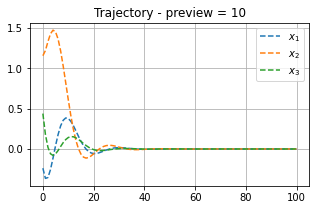

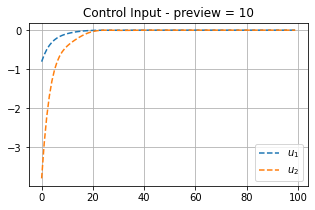

In [6]:
x0 = np.random.randn(3, 1)
N_sim = 100
preview = 10
# for preview in [3, 4, 5, 6, 10, 20]:
x_log, u_log = sim_LinSys(x0, Ad, Bd, LQR_linalg, N_sim, preview)

plot_traj(x_log, u_log, preview)
plot_input(x_log, u_log, preview)

## Batch solution of LQR via CVX

### Remember the matrices
$$
\begin{gathered}
{P}=\left[\begin{array}{ccc|ccc}
Q_0 & \cdots & 0 & 0 & \cdots & 0 \\
\vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
0 & \cdots & P & 0 & \cdots & 0 \\
\hline 0 & \cdots & 0 & R_0 & \cdots & 0 \\
\vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
0 & \cdots & 0 & 0 & \cdots & R_{N-1}
\end{array}\right], \quad {q}=0 \\
{C}=\left[\begin{array}{cccccc|cccc}
A_0 & -I & 0 & \cdots & 0 & 0 & B_0 & 0 & \cdots & 0 \\
0 & A_1 & -I & \cdots & 0 & 0 & 0 & B_1 & \cdots & 0 \\
\vdots & \vdots & \vdots & & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & A_{N-1} & -I & 0 & 0 & \cdots & B_{N-1} \\
\hline I & 0 & 0 & \cdots & 0 & 0 & 0 & 0 & \cdots & 0 \\
0 & 0 & 0 & \cdots & 0 & I & 0 & 0 & \cdots & 0
\end{array}\right], \quad {d}=\left[\begin{array}{c}
0 \\
0 \\
\vdots \\
0 \\
\hline x^{\text {init }} \\
x^{\text {des }}
\end{array}\right]
\end{gathered}
$$

In [7]:
def LQR_cvx(x0, A, B, preview, dim_state, dim_ctrl):
    Q = np.eye(dim_state) * 1
    R = np.eye(dim_ctrl) * 20
    L = np.eye(dim_state) * 100

    n_u = dim_ctrl * preview
    n_x = dim_state * (preview + 1)

    n_var = n_u + n_x
    n_eq  = dim_state * (preview + 1) # dynamics

    C = np.zeros((n_eq, n_var))
    d = np.zeros((n_eq, 1))

    P = np.zeros((n_var, n_var))
    q = np.zeros((n_var, 1))
    for k in range(preview):
        P[k * dim_state:(k+1) * dim_state, k * dim_state:(k+1) * dim_state] = Q
        P[n_x + k * dim_ctrl:n_x + (k+1) * dim_ctrl, n_x + k * dim_ctrl:n_x + (k+1) * dim_ctrl] = R
    P[n_x - dim_state:n_x, n_x - dim_state:n_x] = L

    for k in range(preview):
        C[k * dim_state:(k+1) * dim_state,      k * dim_state:(k+1) * dim_state]       = A
        C[k * dim_state:(k+1) * dim_state,  (k+1) * dim_state:(k+2) * dim_state]       = -np.eye(dim_state)
        C[k * dim_state:(k+1) * dim_state, n_x + k * dim_ctrl:n_x + (k+1) * dim_ctrl]  = B
    
    C[dim_state * preview:dim_state * (preview + 1), 0:dim_state] = np.eye(dim_state)
    d[-dim_state:, 0] = x0

    # Define and solve the CVXPY problem.
    x = cp.Variable(n_var)
    prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),
                     [
                      C @ x == np.squeeze(d),
                    ])
    prob.solve(verbose=False, max_iter = 10000)

    u_act = x.value[n_x:n_x + dim_ctrl]

    return [u_act]

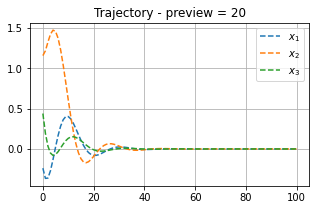

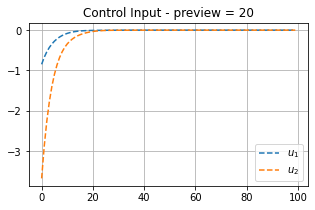

In [8]:
N_sim = 100
preview = 20
# for preview in [3, 4, 5, 6, 10, 20]:
x_log, u_log = sim_LinSys(x0, Ad, Bd, LQR_cvx, N_sim, preview)
plot_traj(x_log, u_log, preview)
plot_input(x_log, u_log, preview)

## Recover the state feedback

As discussed during the lecture, the LQR controller induces a linear state feedback:

$$u_k = K x_k.$$

Now we recover the linear state feedback as follows. 

Given the closed-loop system, we have the matrix of states:

$$X:= \left[x_0, x_1, x_2,\cdots, x_{N-1}, x_N \right] \in \mathbb{R}^{n \times (N+1)}.$$

and the matrix of the input:

$$U:= \left[ u_0, u_1, u_2, \cdots, u_{N-1}, u_N \right] \in \mathbb{R}^{m \times (N+1)}.$$

Then we have:

$$U = K X. $$

If we consider each column of $K$, we have:

$$
K =: \begin{bmatrix}K_1 \\ K_2 \\ \vdots \\ K_m \end{bmatrix}, K_i \in \mathbb{R}^{1\times n}
$$

$$\begin{bmatrix} U_1 \\ U_2 \\ \vdots \\ U_m \end{bmatrix} 
= \begin{bmatrix} K_1x_0 & K_1x_1 & \cdots & K_1x_N \\
                  K_2x_0 & K_2x_1 & \cdots & K_2x_N \\
                  \vdots & \vdots & \vdots & \vdots & \\ 
                  K_mx_0 & K_mx_1 & \cdots & K_mx_N \\ \end{bmatrix},$$

$$
U_i = K_i X, i = 1, 2, \cdots, m.
$$

Thus, we can obtain each column of $K$ via least squares.

The ordinary least squares (OLS) computes the minimum 2-norm solution:

$$
\begin{equation}
\hat{K_i} = \argmin_{K_i} \|U^{T}_i - X^{T}K^{T}_i\|^2
\end{equation}
$$

Via the first-order optimality condition, we have:

$$
\begin{equation}
\begin{aligned}
&\frac{\partial \|U^{T}_i - X^{T}K^{T}_i\|^2}{\partial K^{T}_i}  \\
= &\frac{\partial}{\partial K^T_i} (K_iXX^{T}K^T_i - 2U_iX^{T}K^{T}_i) \\
= & 2 (XX^{T}K^T_i - XU_i^T)
= 0.
\end{aligned}
\end{equation}
$$

Finally, we have:
$$
\hat{K}^{T}_i = (XX^{T})^{-1}XU^{T}_i,
$$

We stack them together:

$$
\hat{K}^T = (XX^{T})^{-1}XU^{T}, \ \ \ \hat{K} = UX^{T}(X^{T}X)^{-1}.
$$

In [9]:
U = u_log.T
X = x_log[1:, :].T
print("The shape of X is:")
print(X.shape)

print("The shape of U is:")
print(U.shape)

# solver for K
# K = U @ X.T @ np.linalg.inv(X @ X.T)
K = U @ np.linalg.pinv(X)


print("The shape of K is:")
print(K.shape)

res = (U - K @ X)
print("The residual is:")
print(np.sqrt(np.sum(res**2)))

print("The K matrix is:")
print(K)

The shape of X is:
(3, 100)
The shape of U is:
(2, 100)
The shape of K is:
(2, 3)
The residual is:
5.8843231336279575e-15
The K matrix is:
[[ 0.62431566 -0.30746496 -1.28033423]
 [ 2.76538864 -1.28033423 -5.7872    ]]


## The influence of preview length

Now we try different preview length and compare the eigevalues of the closed-loop systems. 

We substitute the linear state feedback to the discrete-time system:

$$
\begin{align}
x_{k+1} &= Ax_{k} + Bu_k \\
        &= (A + BK)x_k
\end{align}
$$

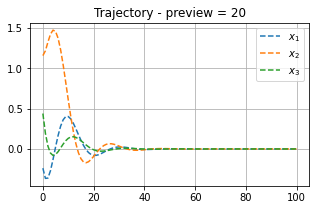

In [10]:
N_sim = 100
preview = 20
x_log, u_log = sim_LinSys(x0, Ad, Bd, LQR_cvx, N_sim, preview)
plot_traj(x_log, u_log, preview)

U = u_log.T
X = x_log[1:, :].T
K = U @ X.T @ np.linalg.inv(X @ X.T)

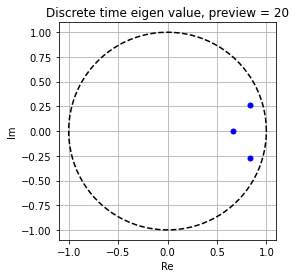

In [11]:
ev, _= np.linalg.eig(Ad + Bd @ K)

for a in ev:
    plt.plot(a.real, a.imag, 'b.', markersize = 10)
plt.plot(np.cos(np.linspace(0, np.pi * 2, 100)), np.sin(np.linspace(0, np.pi * 2, 100)), "k--")

plt.gca().set_aspect('equal')
plt.title("Discrete time eigen value, preview = %d" % preview)
plt.xlabel("Re")
plt.ylabel("Im")

plt.grid()
plt.show()

# Controllability

The **controllability** evaluate whether the input can drive the system to the entire space. 

## State transition

Recall:

$$
x_{k+1} = Ax_k + Bu_k, x_k \in \mathbb{R}^n, u_k \in \mathbb{R}^m.
$$

We have:

$$
x_{k+2} = Ax_{k+1} + Bu_{k+1} = A(Ax_k + Bu_k) + Bu_{k+1} = A^2x_k + ABu_k + Bu_{k+1},
$$

$$
\cdots
$$

$$
\begin{align}
x_N &= A^{N}x_0 + A^{N-1}Bu_0 + A^{N-2}Bu_0 + \cdots Bu_{N-1}  \\
    &= A^{N}x_0 + \left[A^{N-1}B, A^{N-2}B, \cdots, B\right]\begin{bmatrix}u_{N-1} \\ u_{N-2}\\ \vdots \\ u_0 \end{bmatrix}
\end{align}
$$

We define the matrix

$$ \mathcal{C}_N := \left[A^{N-1}B, A^{N-2}B, \cdots, B\right]. $$

We find that if $\mathcal{C}_N$ has full column rank, we can choose the sequence of $\left[u_0, u_1, \cdots, u_{N-1}\right]$ to any states. 

Now we do some re-ordering to group the columns corresponding to each input. Let $B = [B_1, B_2, \cdots, B_m]$, then we have:

$$
\mathcal{C}_N^{(i)} = \left[A^{N-1}B_i, A^{N-2}B_i, \cdots, B_i\right] \in \mathbb{R}^{n \times N}.
$$

Thus, the re-ordered $\mathcal{C}_N$ matrix becomes:

$$
\hat{\mathcal{C}}_N = \left[\mathcal{C}_N^{(1)}, \mathcal{C}_N^{(2)}, \cdots, \mathcal{C}_N^{(m)}  \right].
$$

## n-step is necessary

We consider each input separately. For each $\mathcal{C}_N^{(i)}$, $\operatorname{Rank}(\mathcal{C}_N^{(i)}) \le n$. To make $\mathcal{C}_N^{(i)}$ have full rank, one need to consider at least $n$-steps of inputs. 

Thus, if $\operatorname{Rank}(\mathcal{C}_n^{(i)}) = n$, we can say that the system, $[A, B_i]$ is **controllable**. 

For multiple input case, we say the system $[A, B]$ is **controllable** if $\operatorname{Rank}(\mathcal{C}_N)$ has full rank. 

## n-step is sufficient

The Cayley Hamilton Theorem suggests that, for $A \in \mathbb{R}^{n\times n}$, $A^n$ can be represented by summation of $A^k, k \le n-1$:

$$
A^n = a_0I + a_1A  + a_2A^2 + \cdots + a_{n-1}A^{n-1}. 
$$

Thus, for $N > n$, the state will still stay in the range of $\mathcal{C}_n$. 

## Examples:

### Controllable

A controllable system, 3-order integrator. 

By control the $4$-order acceleration, the system can go to anywhere in the statespace. 

$$ 
\begin{aligned}
\dot{x_1} &= x_2 \\
\dot{x_2} &= x_3 \\
\dot{x_3} &= u \\
\end{aligned}
$$

### Stabilizable


A uncontrollable system. A 2-order integrator appending a stable first-order system. 

The control input can do nothing to the third dimension, but $x_3$ will converge to $0$. 

$$ 
\begin{aligned}
\dot{x_1} &= x_2 \\
\dot{x_2} &= u \\
\dot{x_3} &= -0.1x_3 \\
\end{aligned}
$$

### Unstabilizable

A uncontrollable system. A 2-order integrator appending a unstable first-order system. 

The control input can do nothing to the third dimension, and $x_3$ will explode. 

$$ 
\begin{aligned}
\dot{x_1} &= x_2 \\
\dot{x_2} &= u \\
\dot{x_3} &= 0.1x_3 \\
\end{aligned}
$$


The controllability matrix:
[[0.005 0.015 0.025]
 [0.1   0.1   0.1  ]
 [0.    0.    0.   ]]
The rank:
2


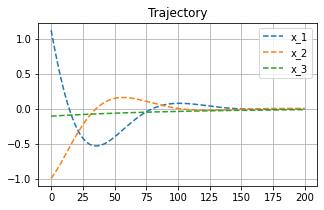

In [12]:
## Controllable system
# Bc = np.array([[1], 
#                [1],
#                [1]])

# Ac = np.array([[0, 1, 0],
#                [0, 0, 1],
#                [0, 0, 0]])

## Uncontrollable system, but can be stabilized. 
Bc = np.array([[0], 
               [1],
               [0]])

Ac = np.array([[0, 1,    0],
               [0, 0,    0],
               [0, 0, -0.1]])

## Uncontrollable system, and can not be stabilized. 
# Bc = np.array([[0], 
#                [1],
#                [0]])

# Ac = np.array([[0, 1,    0],
#                [0, 0,    0],
#                [0, 0, 0.1]])


## I am using the infinite series ...
Ad = np.eye(3) + Ac * dt + Ac @ Ac * dt**2 / 2
Bd = Bc * dt + Ac @ Bc * dt**2 / 2

C = np.concatenate((Bd, Ad @ Bd, Ad @ Ad @ Bd), axis = 1)

print("The controllability matrix:")
print(C)

print("The rank:")

print(np.linalg.matrix_rank(C))

######
N_sim = 200
preview = 8
x0 = np.random.randn(3, 1)
x_log, u_log = sim_LinSys(x0, Ad, Bd, LQR_linalg, N_sim, preview)

plt.figure(figsize=(5, 3))

plt.plot(x_log[:, 0], '--', label = "x_1")
plt.plot(x_log[:, 1], '--', label = "x_2")
plt.plot(x_log[:, 2], '--', label = "x_3")

plt.title('Trajectory')
plt.legend()
plt.grid()
plt.show()


## Reference

[1] https://en.wikipedia.org/wiki/Cayley%E2%80%93Hamilton_theorem